Pedro Vincenty

HW 3 

Link to download json file of reviews and ratings for 100 movies scrapped on rotten tomatoes:

https://drive.google.com/file/d/1IgznTPo0OY_bZviQD-zj8jrcyVqPIC-C/view?usp=drive_link

In [20]:
#import relevant libraries
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import time 
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
#Write list of dictionaries as json file.  ensure_ascii argument ammends issue of '\201c' output to ' " '
with open('./Pedro_Vincenty_movie_data.json', 'r',encoding='utf-8') as file:
    test = json.load(file)

In [4]:
# convert our list of dictionaries into a dataframe
testdf = pd.DataFrame(test)

In [5]:
# map rotten and fresh to 0 and 1 
testdf['rating'] = testdf['rating'].map({'rotten': 0, 'fresh': 1})

In [6]:
# Set dependent and independent variable
X_text = testdf['text']
Y = testdf['rating']

In [7]:
# Create a vectorizer that will track text as counted features
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model
logistic_regression = LogisticRegression(max_iter=100000)

# Use this model and our data to get 5-fold cross validation accuracy
accs = cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average AUC rounded to three decimal points
print(f"The accuracy of our classifier is {np.mean(accs):3f}")

The accuracy of our classifier is 0.993573


In [8]:
logistic_regression.fit(X, Y)


LogisticRegression(max_iter=100000)

In [9]:
# Define function that clicks for next page a "page number - 1" number of times so there isn't an extra click on the last iteration
# else clause clicks for the next page and checks if next page xpath exists and loops accordingly
page_num = 5
#browser = webdriver.Chrome()

def stop_extra_click():
    if i == page_num-1:
        return True
    else:
        try:
            browser.find_element(By.XPATH,xp).click()
            time.sleep(2)
            return False
        except NoSuchElementException:
            print("No more reviews")
            return True

In [10]:
# Get reviews from another movie

link = "https://www.rottentomatoes.com/m/silence_2017/reviews"

# Open browser
browser = webdriver.Chrome()
browser.maximize_window()
# Go to the link
browser.get(link)
# cp path for next button for rotten tomatoes all critics' page 
xp = "//rt-button[@class = 'next']"

rating = []
text = []
#click on that object at "page_num" of times
for i in range(page_num):

    # parse the page to a soup
    page_source = browser.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    reviews_content = soup.find_all('div', class_="review-row")

    # for loop that finds values corresponding to variable name
    for review in reviews_content:
        review_rating = review.find('score-icon-critic-deprecated')['state'] # <<< Get the rating  >>>
        review_text = review.find('p',{'class':'review-text'}).text # <<< Get the source  >>>

        #append findings to relative lists
        rating.append(review_rating)
        text.append(review_text)


    #logic to break out of loop    
    if stop_extra_click() == True:
        break
    time.sleep(2)

In [11]:
#Initialize a list "test"
test = []
#Gather the ratings and review texts from the movie "silence" into a dictionary called "data"
for k in range(0,len(rating)):
    data = {
    'rating': rating[k],
    'text':text[k]
    }
    test.append(data)

In [12]:
# set data dictionary created above to a dataframe
test2Df = pd.DataFrame(test)

In [13]:
# Map rotten and fresh to 0 and 1 respectively
test2Df['rating'] = test2Df['rating'].map({'rotten': 0, 'fresh': 1})

In [14]:
# Transform the text column of the data from the test movie to be interpreted by the count vectorizer
X_new = count_vectorizer.transform(test2Df['text'])

# Make predictions on the new data
predictions = logistic_regression.predict(X_new)

In [15]:
# Take dataframe of new movie and concatenate with the predictions made based on the model 
df = pd.DataFrame({"review":test2Df['text'], "Rating":test2Df['rating'], "Prediction":predictions})

In [16]:
# Assuming Rating is the actual values for the new data
accuracy = accuracy_score(df["Rating"], predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 89.00%


In [17]:
# See where prediction is 0 or rotten
df[df['Prediction']==0]

,review,Rating,Prediction
2,Silence is an example that with passion a film...,1,0
15,"""Silence"" feels like throwing stones in a dese...",0,0
16,The film completes what would be Scorsese's sp...,1,0
19,Scorsese has been trying to get this film thro...,0,0
28,There doesn't appear to be much of a target au...,0,0
29,"It was manipulative, unfeeling, exploitative j...",0,0
36,"If nothing else, you've got to hand it to Mart...",0,0
47,"[""Silence""] only seeks to uphold that which it...",0,0
49,This meditation on faith and humanity left me ...,0,0
51,"Suffers from a total lack of dramatic rhythm, ...",0,0


In [18]:
# See where prediction is 1 or fresh

df[df['Prediction']==1]

,review,Rating,Prediction
0,“Silence” seeks to be something more – a spiri...,1,1
1,"No matter what you believe, Scorsese's film te...",1,1
3,Silence is a somber film full of stellar perfo...,1,1
4,[Scorsese's] most challenging film to date: a ...,1,1
5,Silence is an uncomfortable and unsettling wat...,1,1
...,...,...,...
95,"Despite the difficult nature of the material, ...",1,1
96,Scorsese is indulgently using an epic setting ...,0,1
97,"Repetitive, a little boring, but also calming ...",1,1
98,A richly detailed study of faith as a force of...,1,1


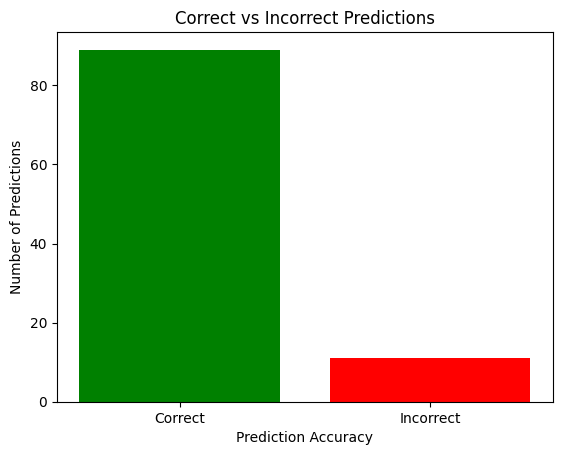

In [26]:
# Determine correct and incorrect predictions
correct_predictions = np.sum(df['Rating'] == df['Prediction'])
incorrect_predictions = np.sum(df['Rating'] != df['Prediction'])

# Create a bar chart
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Number of Predictions')
plt.title('Correct vs Incorrect Predictions')

# Display the plot
plt.show()